In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE
import albumentations as A
from functools import partial

import wandb
from wandb.keras import WandbCallback

In [ ]:
DATA_ROOT = "C:\\Users\\Student\\Desktop\\Kamilio\\Br35H"

# define SSL model constants
MODEL_SSL = "model_v1.3.0"
DATASET_SSL = "data_v1.3.0"
MAP_DICT = {'0': '2', '1': '4', '2': '6', '3': '8', '4': '10'}
SAMPLE_DICT = {'0': [], '1': [], '2': [], '3': [], '4': []}

# define constants for model fine-tuning
MODEL_FINE_TUNE = "model_v1.0.9"
DATASET_FINE_TUNE = "data_v1.0.0"

IMG_SIZE = 128
MINI_BATCH_SIZE = 32

## Load necessary functions

In [ ]:
transforms = A.Compose([
    A.HorizontalFlip(0.5),
    A.VerticalFlip(0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
])

In [ ]:
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return int(one_hot)

In [ ]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    return img

In [ ]:
def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    # Resize and norm the image
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[IMG_SIZE, IMG_SIZE])
    return aug_img

In [ ]:
def process_image(image):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    return aug_img

In [ ]:
def process_path(file_path, use_augmentations=False):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    image = tf.io.read_file(file_path)
    image = decode_img(image)
    if use_augmentations:
        image = process_image(image)
    return image, label

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers

def build_model_SSL(class_count: int):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights=None)
    model.summary()

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization(name='batch_normalization')(x)
    outputs = layers.Dense(class_count, activation="softmax", name="pred")(x)

    model = tf.keras.Model(inputs, outputs, name='EfficientNetB0')
    
    return model

## Visiaulize samples from pre-text dataset

In [ ]:
class_names = os.listdir(os.path.join(DATA_ROOT, DATASET_SSL,'train'))

rot_train_dataset_eg = tf.data.Dataset.list_files(f"{DATA_ROOT}\\{DATASET_SSL}\\train\\*\\*", shuffle=False)
rot_train_dataset_eg = rot_train_dataset_eg.shuffle(len(rot_train_dataset), reshuffle_each_iteration=False)
rot_train_dataset_eg = rot_train_dataset_eg.map(process_path, num_parallel_calls=AUTOTUNE).batch(1)

In [ ]:
iterator=iter(rot_train_dataset)

for _ in range(500):
    sample = next(iterator)
    image = sample[0].numpy().reshape(IMG_SIZE,IMG_SIZE,3)
    label = tf.math.argmax(sample[1], axis=1).numpy()[0]
    SAMPLE_DICT[str(label)].append(image)

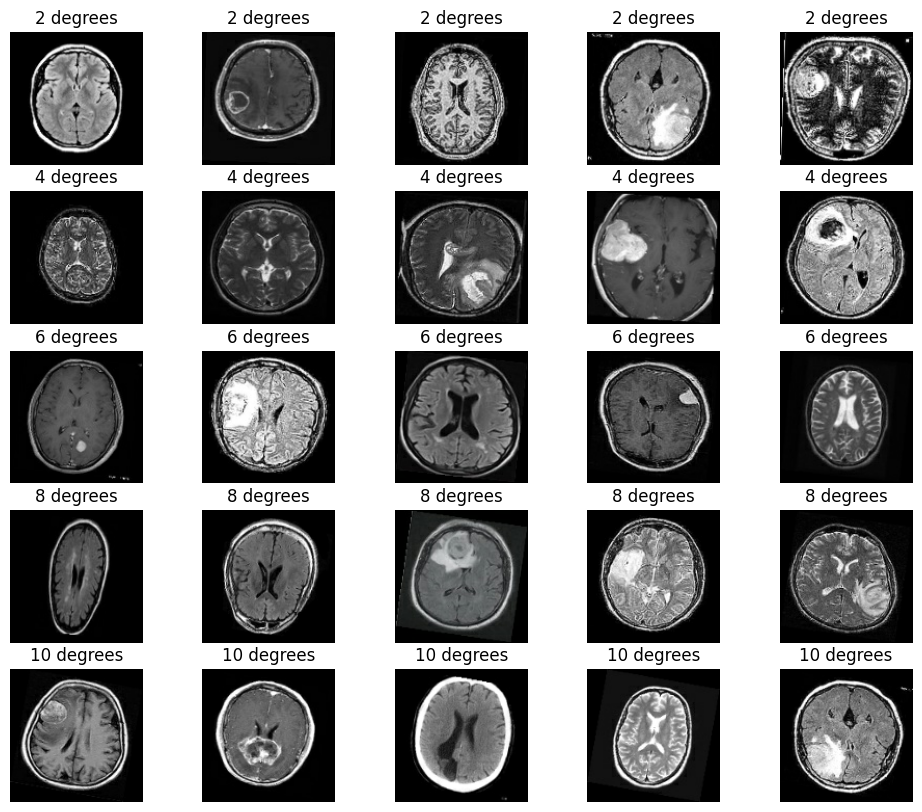

In [21]:
class_count = len(SAMPLE_DICT)
plt.figure(figsize=(12,10))
i=1
for row in range(class_count):
    for column in range(5):
        plt.subplot(class_count, 5, i)
        image = SAMPLE_DICT[str(row)][column]
        rot_angle = MAP_DICT[str(row)]
        plt.imshow(image)
        plt.title(f'{rot_angle} degrees')
        plt.axis('off')
        i += 1

## Visiaulize samples from downstream taskdataset

In [ ]:
class_names = os.listdir(os.path.join(DATA_ROOT, DATASET_FINE_TUNE,'train'))
map_dict = {'0': 'non-tumorous', '1': 'tumorous'}
sample_dict = {'0': [], '1': []}

train_dataset_eg = tf.data.Dataset.list_files(f"{DATA_ROOT}\\{DATASET_FINE_TUNE}\\train\\*\\*", shuffle=False)
train_dataset_eg = train_dataset_eg.shuffle(len(rot_train_dataset), reshuffle_each_iteration=False)
train_dataset_eg = train_dataset_eg.map(partial(process_path, use_augmentations=True), num_parallel_calls=AUTOTUNE).batch(1)

In [ ]:
iterator=iter(train_dataset_eg)

for _ in range(500):
    sample = next(iterator)
    image = sample[0].numpy().reshape(IMG_SIZE,IMG_SIZE,3)
    label = tf.math.argmax(sample[1], axis=1).numpy()[0]
    sample_dict[str(label)].append(image)

In [ ]:
class_count = len(sample_dict)
plt.figure(figsize=(14,4))
i=1
for row in range(class_count):
    for column in range(7):
        plt.subplot(class_count, 7, i)
        image = sample_dict[str(row)][column]
        classs = map_dict[str(row)]
        plt.imshow(image)
        plt.title(f'{classs}')
        plt.axis('off')
        i += 1

## Load datasets

In [ ]:
class_names = os.listdir(os.path.join(DATA_ROOT, DATASET_SSL, 'train'))

rot_train_dataset = tf.data.Dataset.list_files(f"{DATA_ROOT}\\{DATASET_SSL}\\train\\*\\*", shuffle=False)
rot_train_dataset = rot_train_dataset.shuffle(len(rot_train_dataset), reshuffle_each_iteration=False)
rot_train_dataset = rot_train_dataset.map(process_path, num_parallel_calls=AUTOTUNE).batch(MINI_BATCH_SIZE)

rot_val_dataset = tf.data.Dataset.list_files(f"{DATA_ROOT}\\{DATASET_SSL}\\val\\*\\*", shuffle=False)
rot_val_dataset = rot_val_dataset.shuffle(len(rot_val_dataset), reshuffle_each_iteration=False)
rot_val_dataset = rot_val_dataset.map(process_path, num_parallel_calls=AUTOTUNE).batch(MINI_BATCH_SIZE)

In [ ]:
class_names = os.listdir(os.path.join(DATA_ROOT, DATASET_FINE_TUNE, 'train'))

train_dataset = tf.data.Dataset.list_files(f"{DATA_ROOT}\\{DATASET_FINE_TUNE}\\train\\*\\*", shuffle=False)
train_dataset = train_dataset.shuffle(len(train_dataset), reshuffle_each_iteration=False)
train_dataset = train_dataset.map(partial(process_path, use_augmentations=True), num_parallel_calls=AUTOTUNE).batch(MINI_BATCH_SIZE)

val_dataset = tf.data.Dataset.list_files(f"{DATA_ROOT}\\{DATASET_FINE_TUNE}\\val\\*\\*", shuffle=False)
val_dataset = val_dataset.shuffle(len(val_dataset), reshuffle_each_iteration=False)
val_dataset = val_dataset.map(partial(process_path, use_augmentations=True), num_parallel_calls=AUTOTUNE).batch(MINI_BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(f"{DATA_ROOT}\\{DATASET_FINE_TUNE}\\test\\*\\*", shuffle=False)
test_dataset = test_dataset.shuffle(len(test_dataset), reshuffle_each_iteration=False)
test_dataset = test_dataset.map(partial(process_path, use_augmentations=True), num_parallel_calls=AUTOTUNE).batch(1)

## Initialize and train model for rotation angle classifiction pre-text task

In [ ]:
run = wandb.init(project="SSL_transfer_learning",
                 entity = 'ssl_bakalauras',
                 name = MODEL_SSL,
                 config={
                     "dataset_name": DATASET_SSL,
                     "dataset_origin": "Br35H",
                     "initial_weights": "Randomly initialized",
                     "task": "pre_text - rotation angle classification",
                     "pre_text_angles": str(MAP_DICT),
                     "frozen_layers": "None",
                     "loss_function": "categorical_crossentropy",
                     "learning_rate": 0.001,
                     "batch_size": MINI_BATCH_SIZE,
                     "epochs": 100,
                     })

config = wandb.config

# Initialize model
tf.keras.backend.clear_session()
model = build_model_SSL(class_count = 5)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
model.compile(optimizer=optimizer, loss=config.loss_function, metrics = ['acc'])
model.summary()

In [ ]:
model.fit(rot_train_dataset,
          epochs=config.epochs,
          validation_data=rot_val_dataset,
          callbacks=[WandbCallback(save_model=(False))])

In [ ]:
run.finish()

In [ ]:
model.save(f"C:\\Users\\Student\\Desktop\\Kamilio\\models\\{MODEL_SSL}")

## Fine-tune pretrained model for brain tumor classification task

In [ ]:
model = tf.keras.models.load_model(f"C:\\Users\\Student\\Desktop\\Kamilio\\models\\{MODEL_SSL}")

In [ ]:
run = wandb.init(project="SSL_transfer_learning",
                 entity = 'ssl_bakalauras',
                 name = MODEL_FINE_TUNE,
                 config={
                     "dataset_name": DATASET_FINE_TUNE,
                     "dataset_origin": "Br35H",
                     "transformations": str(transforms),
                     "initial_weights": MODEL_SSL,
                     "task": "tumorous/non-tumorous brain classification",
                     "frozen_layers": "All backbone layers",
                     "loss_function": "categorical_crossentropy",
                     "learning_rate": 0.001,
                     "batch_size": MINI_BATCH_SIZE,
                     "epochs": 200,
                     })

config = wandb.config

# Initialize model
tf.keras.backend.clear_session()


# Reinitializing dense classification layer
inputs = model.input

x = model.layers[-4].output
x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization(name='batch_normalization')(x)
outputs = layers.Dense(2, activation="softmax", name="pred")(x)

model2 = tf.keras.Model(inputs, outputs, name="EfficientNetB0")

# Freezing the Convolutional Layers while keeping Dense layers as Trainable
for layer in model2.layers:
    if not (layer.name in ['pred', 'batch_normalization']):
        layer.trainable=False
    else:
        layer.trainable=True

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
model2.compile(optimizer=optimizer, loss=config.loss_function, metrics = ['acc', tf.keras.metrics.AUC()])
model2.summary()

In [ ]:
# Training the model on Downstream Task
model2.fit(train_dataset, validation_data=val_dataset, epochs=config.epochs, callbacks=[WandbCallback(save_model=(False))])

In [ ]:
test_loss, test_acc, test_auc = model2.evaluate(test_dataset)

In [ ]:
wandb.log({
    "test_loss": test_loss,
    "test_acc": test_acc,
    "test_auc": test_auc
})

In [ ]:
run.finish()

In [ ]:
model2.save(f"C:\\Users\\Student\\Desktop\\Kamilio\\models\\{MODEL_FINE_TUNE}")